# Data analysis of the systematic review

## 1. Data processing

### Step 1: Import data and packages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker

In [2]:
data = pd.read_csv('litrev_data.csv')

In [3]:
sns.set(font_scale=1.2, style="ticks")

### Step 2: Only keep the studies that met the inclusion criteria and convert columns into the right data types.

In [4]:
data = data[data.Included=='yes'].reset_index()
data = data.astype({'Repetitiveness score': 'int', 'Year': 'int', 'N citations': 'float'})  # Convert to the right data types

In [5]:
# Convert the sample sizes into integers
N = []
for x in data["Sample size"] : 
    if x == '1G' : x = 1
    elif x == '2G' : x = 2
    elif x== '1G, 3' : x = 4
    elif x == '5G' : x = 5
    elif isinstance(x, float) : x = 0 # Case where the sample size is NaN: put N=0 as a convention
    N.append(int(x))
data["Sample size"] = N # Saved in a new column

# Convert the nearest-neighbour distances into floats
nn = []
for x in data["NN distance (m)"]:
    if isinstance(x, float) : nn.append(None)
    else : nn.append(eval(x.replace(",", "." )))  
data["NN distance (m)"] = nn

# Make the difference between hummingbirds (nectarivores) and non-nectarivore birds for the subsequent analyses
group = []
for (x,y) in zip(data.Group, data.Taxa) : 
    if x=="Birds" and y=="Hummingbirds" : group.append("Hummingbirds")
    elif x=="Birds" and y!="Hummingbirds" : group.append("Other birds")
    else : group.append(x)
data["Group"] = group

# Add an extra-column that states whether the animal is a bee for subsequent analyses 
data["Bee"] = (data.Taxa == "Bumblebees") | (data.Taxa == "Honeybees") | (data.Taxa == "Solitary bees")

### Step 3: Add additional information

Add columns (1) that asses possible biases in studies, (2) that is a categorical variable for the number of citations, (3) that gives the number of citations per year of the study (4) that asses whether the definition of route repetitiveness was qualitative or quantitative

In [6]:
long_dist_tracking=["GPS", "Radio telemetry", "Radar tracking"] # Define the long distance tracking methods

bias = [] # Note the possible biases
ncit= [] # Create categories for the number of citations
ncit_per_year= [] # Compute the number of citations per year
qual=[] # Defines if the study was qualitative or quantitative

for i in range (len(data.index)) :
    
    if data.loc[i,"Metric #1"] == "Qualitative" or data.loc[i,"Metric #2"] == "Qualitative" or data.loc[i,"Metric #3"] == "Qualitative": 
        bias.append("Qualitative definition")
        qual.append("Qualitative")
    elif data.loc[i,"Exclusion of revisits"] == "Yes" : 
        bias.append("Revisits excluded")
        qual.append("Quantitative")
    elif data.loc[i,"Observation method #1"] in long_dist_tracking or data.loc[i,"Observation method #2"] in long_dist_tracking or data.loc[i,"Observation method #3"] in long_dist_tracking : 
        bias.append('Long distance tracking')
        qual.append("Quantitative")
    else : 
        bias.append("")
        qual.append("Quantitative")


    x = data.loc[i, "N citations"]
    if x < 50 : ncit.append("0-50")
    elif x < 100 : ncit.append("50-100")
    elif x < 150 : ncit.append("100-150")
    elif x < 200 : ncit.append("150-200")
    elif x < 250 : ncit.append("200-250")
    else : ncit.append('250+')

    age_study = 2023 - int(data.loc[i, "Year"])
    if age_study == 0 : age_study = 1
    ncit_per_year.append(x/age_study)

data["Possible bias"] = bias
data["N citations cat"] = ncit
data["Ncit/year"] = ncit_per_year
data["Definition"] = qual

Create a dataframe with 1 line/study. The traplining score or a study will be the mean of the repetitiveness score of all subjects (weighted by the sample size of each condition).

In [7]:
data["Temp sample size"] = data["Sample size"]
data.loc[data["Temp sample size"] == 0, "Temp sample size"] = 1 # Helps with the weighing function

data_uniquestudy = pd.DataFrame({})
data_uniquestudy["Mean repetitiveness score"] = data.groupby(data.ID).apply(lambda x: np.average(x["Repetitiveness score"], weights=x["Temp sample size"]))
data_uniquestudy["Sample size"] = data.groupby(data.ID).sum("Sample size")["Sample size"]
data_uniquestudy = data_uniquestudy.merge(data.drop_duplicates("ID").set_index("ID"), on='ID')
data_uniquestudy.rename(columns={'Sample size_x':'Sample size'}, inplace=True)

Create a dataframe with the diffferent metrics used for each study. Same with the observation methods.

In [8]:
metric_type = []
metric_list = []
study_date = []
group = []
taxa = []
diet = []
repetitiveness_score = []
n= []

for i in data_uniquestudy.index :
    for type, metric in {'Metric type #1':"Metric #1", 'Metric type #2':"Metric #2", 'Metric type #3':"Metric #3"}.items() : 
        
        if isinstance(data_uniquestudy.loc[i, type], str) :
            metric_type.append(data_uniquestudy.loc[i, type])
            metric_list.append(data_uniquestudy.loc[i, metric])
            study_date.append(data_uniquestudy.loc[i, "Year"])
            group.append(data_uniquestudy.loc[i, "Group"])
            taxa.append(data_uniquestudy.loc[i, "Taxa"])
            diet.append(data_uniquestudy.loc[i, "Diet"])
            repetitiveness_score.append(data_uniquestudy.loc[i, "Mean repetitiveness score"])
            n.append(data_uniquestudy.loc[i, "Sample size"])

metric_df = pd.DataFrame({'Year': study_date, 'Metric type': metric_type, 'Metric': metric_list, "Group": group, "Taxa": taxa, 
                          "Diet":diet,"Repetitiveness score": repetitiveness_score, "Sample size":n})

In [9]:
method = []
study_date = []
score = []

for i in data_uniquestudy.index :
    for m in ['Observation method #1', 'Observation method #2','Observation method #3'] : 
        if isinstance(data_uniquestudy.loc[i, m], str) :
            method.append(data_uniquestudy.loc[i, m])
            study_date.append(data_uniquestudy.loc[i, "Year"])
            score.append(data_uniquestudy.loc[i, "Mean repetitiveness score"])
            group.append(data_uniquestudy.loc[i, "Group"])

method_df = pd.DataFrame({'Year': study_date, 'Observation method': method, "Repetitiveness score": score})

## 2. Descriptive statistics

Set up a color palette that matches the different groups of taxa. In shades of blue, nectarivores. In shades of orange, other diets.

In [10]:
color_gradient_1 = sns.color_palette("Blues", 10)
color_gradient_2 = sns.color_palette("YlOrBr", 10)
customPalette = []
for i in [9,6,4] : customPalette.append(color_gradient_1[i])
for i in [4,6,9] : customPalette.append(color_gradient_2[i])
customPalette = sns.color_palette(customPalette)

### Fig 1.B. Categorical plot of the study setting for each taxa

<ipython-input-11-74ea6e1bf7fc>:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


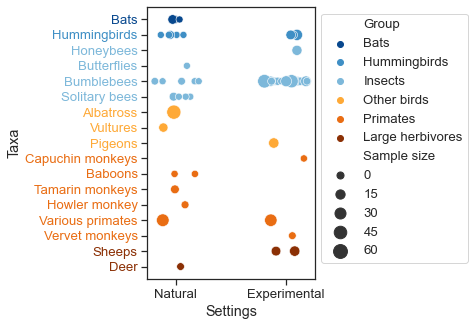

In [11]:
n_taxa = {"Bats":1, "Hummingbirds":1, "Insects":4, "Other birds":3, "Primates": 6, "Large herbivores": 2}
custom_dict = {"Bats":0, "Hummingbirds":1, "Insects":2, "Other birds":3, "Primates": 4, "Large herbivores": 5}

data_uniquestudy["Setting_bis"]=(data_uniquestudy["Setting"]=="Experimental").apply(lambda x: np.random.normal(loc=x, scale=0.1))
data_uniquestudy = data_uniquestudy.sort_values("Group", key=lambda x: x.map(custom_dict))

fig, ax = plt.subplots(1,1,figsize=(3,5))
g = sns.scatterplot(ax=ax,data=data_uniquestudy, y="Taxa", x="Setting_bis", hue="Group", size="Sample size", sizes=(50,200), palette = customPalette, legend='brief')

row = 0 
for key, value in custom_dict.items() :
    for i in range (n_taxa[key]):
        g.axes.get_yticklabels()[row].set_color(customPalette[value])
        row+=1

ax.set_xticks([0, 1])
ax.set_xticklabels(["Natural", "Experimental"])
ax.set_xlabel("Settings")

plt.legend(bbox_to_anchor=(1.,1))
plt.tight_layout()
plt.show()

### Fig 1.A. Histogram of the different repetitiveness metrics

Text(0.5, 0, 'Metrics')

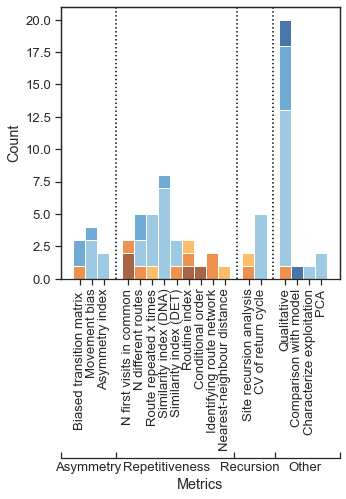

In [12]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

taxa_order = list(data_uniquestudy["Taxa"].drop_duplicates())
taxa_order_dict = {taxa_order[i]:i for i in range (len(taxa_order))}

metric_df = metric_df.sort_values(by=['Taxa'], key=lambda x: x.map(taxa_order_dict))

custom_dict = {'Asymmetry': 0, 'Repetitiveness': 1, 'Recursion': 2, 'Other':3} 

metric_mapping={'Biased transition matrix ': 0, 'Movement bias': 1, 'Asymmetry index': 2, 
                'N first visits in common': 4, 'N different routes': 5, 'Route repeated x times': 6,'Similarity index (DNA)': 7, 
                'Similarity index (DET)': 8, 'Routine index': 9, 'Conditional order':10, 'Identifying route network': 11, 'Nearest-neighbour distance':12,
                'Site recursion analysis': 14, 'CV of return cycle': 15,
                'Qualitative': 17, 'Comparison with model': 18, 'Characterize exploitation': 19, 'PCA': 20}
list_labels = ['' for i in range (21)]
for metric, i in metric_mapping.items() : list_labels[i]=metric


metric_bis = [metric_mapping[m] for m in metric_df["Metric"]]
metric_df["Metric_bis"]=metric_bis

h = sns.histplot(data=metric_df, x="Metric_bis", hue='Group',multiple='stack', bins=21, ax=ax,  palette=customPalette, legend=None)


binwidth = 20/21

ax.set_xlabel('')
list_ticks = list(np.arange(1-binwidth/2, 20+binwidth/2, binwidth))
removed_ticks = []
for x in [3, 12, 14] : removed_ticks.append(list_ticks.pop(x))
ax.set_xticks(list_ticks)
ax.set_xticklabels(list(metric_mapping.keys()))

ax.xaxis.set_tick_params(rotation=90)


for x in removed_ticks : 
    ax.axvline(x, color='black', linestyle=':')

ax1 = ax.twiny()

ax1.spines["bottom"].set_position(("axes", -0.66))
ax1.tick_params('both', length=0, width=0, which='minor')
ax1.tick_params('both', direction='in', which='major')
ax1.xaxis.set_ticks_position("bottom")
ax1.xaxis.set_label_position("bottom")

ax1.set_xticks([0, 2 , 6.2, 7.7, 10])
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_locator(ticker.FixedLocator([1, 3.8 , 6.8, 8.75]))
ax1.xaxis.set_minor_formatter(ticker.FixedFormatter(['Asymmetry', 'Repetitiveness', 'Recursion', 'Other']))

ax1.set_xlabel('Metrics')

### Diverse numbers to quantify the studies

In [13]:
# Ratio number of taxa / number of metrics
len(np.unique(metric_df["Taxa"]))/len(np.unique(metric_df["Metric"]))

0.9444444444444444

In [14]:
# Propotion of nectarivores 
np.sum (data_uniquestudy.Diet == "Nectarivore")/len(data_uniquestudy.index)

0.7358490566037735

In [15]:
# Proportion of studies about bees
np.sum (data_uniquestudy.Bee)/len(data_uniquestudy.index)

0.5094339622641509

In [16]:
# Proportion of qualitative studies
np.sum( (data["Metric #1"]=="Qualitative") | (data["Metric #2"]=="Qualitative") | (data["Metric #3"]=="Qualitative"))/len(data.index)

0.313953488372093

In [17]:
sns.set(font_scale=1.5, style="ticks")

In [18]:
data["Repetitiveness score noisy"] = data["Repetitiveness score"].apply(lambda x: np.random.normal(loc=x, scale=0.1)) # Add some jitter to the points to help see better

### Fig 1.C. Density of repetitiveness scores for each animal group

<ipython-input-36-df1e98947ea6>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averages = data.groupby('Group').mean()["Repetitiveness score"]
c:\Users\julia\anaconda3\lib\site-packages\seaborn\axisgrid.py:677: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


Group
Bats                2.666667
Hummingbirds        3.083333
Insects             2.433962
Large herbivores    1.500000
Other birds         3.333333
Primates            2.250000
Name: Repetitiveness score, dtype: float64


c:\Users\julia\anaconda3\lib\site-packages\seaborn\axisgrid.py:677: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\julia\anaconda3\lib\site-packages\seaborn\axisgrid.py:677: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\julia\anaconda3\lib\site-packages\seaborn\axisgrid.py:677: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\julia\anaconda3\lib\site-packages\seaborn\axisgrid.py:677: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\julia\anaconda3\lib\site-packages\seaborn\axisgrid.py:677: FutureWarning: iteritems is deprecated and will be r

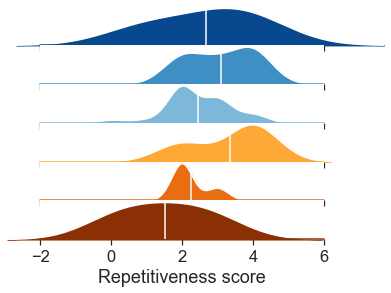

In [36]:
custom_dict = {"Bats":0, "Hummingbirds":1, "Insects":2, "Other birds": 3, "Primates": 4,  "Large herbivores": 5}
data = data.sort_values(by=['Group'], key=lambda x: x.map(custom_dict))

averages = data.groupby('Group').mean()["Repetitiveness score"]
print(averages)

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(data, row='Group', hue="Group", row_order = custom_dict.keys(), hue_order=custom_dict.keys(), aspect=7, height=0.7, palette = customPalette, sharey=False)


# then we add the densities kdeplots for each month
g.map(sns.kdeplot, 'Repetitiveness score', 
      clip_on=False, fill=True, alpha=1., linewidth=1.5)


# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 'Repetitiveness score',
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0, lw=1.5, clip_on=False)

#add vertical line for average
axes = g.axes
axes[0,0].axvline(x=averages['Bats'],color='w')
axes[1,0].axvline(x=averages['Hummingbirds'],color='w')
axes[2,0].axvline(x=averages['Insects'],color='w')
axes[3,0].axvline(x=averages['Other birds'],color='w')
axes[4,0].axvline(x=averages['Primates'],color='w')
axes[5,0].axvline(x=averages['Large herbivores'],color='w')


# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
g.fig.subplots_adjust(hspace=-0.002)

# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.setp(ax.get_xticklabels(), fontsize=15)
plt.xlabel('Repetitiveness score', fontsize=18)
plt.xlim(-2,6)


plt.show()

### Fig 2.A. Repetitiveness score depending on the distance between neighbouring sites

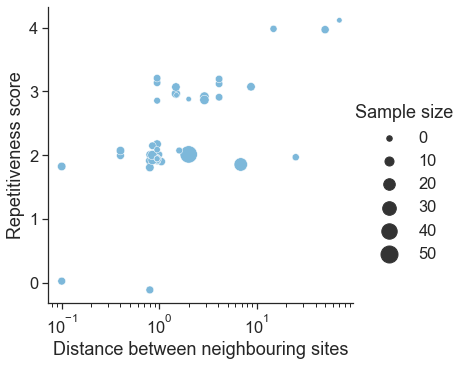

In [23]:
g = sns.relplot(data=data[data.Bee==True], x="NN distance (m)", y="Repetitiveness score noisy", size="Sample size", sizes=(30,300), color=customPalette[2])
g.set(xscale="log")
plt.ylabel("Repetitiveness score")
plt.xlabel("Distance between neighbouring sites")
plt.show()

### Fig 2.B. Repetitiveness score depending on the number of available sites

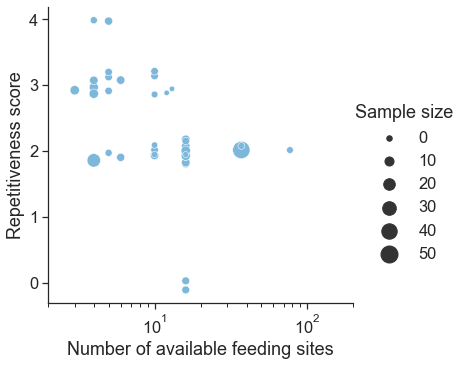

In [22]:
g = sns.relplot(data=data[(data["Available/used"]=="Available")&(data.Bee==True)], x="N feeding sites", 
                y="Repetitiveness score noisy", size="Sample size", sizes=(30,300),color=customPalette[2])
plt.xscale("log")
plt.ylabel("Repetitiveness score")
plt.xlabel("Number of available feeding sites")
plt.xlim(2,200)
plt.show()

## 3. Inferential statistics

In [25]:
import scipy.stats
import scikit_posthocs as sp
from statannotations.Annotator import Annotator

### Step 1. Test if the distribution is normal:

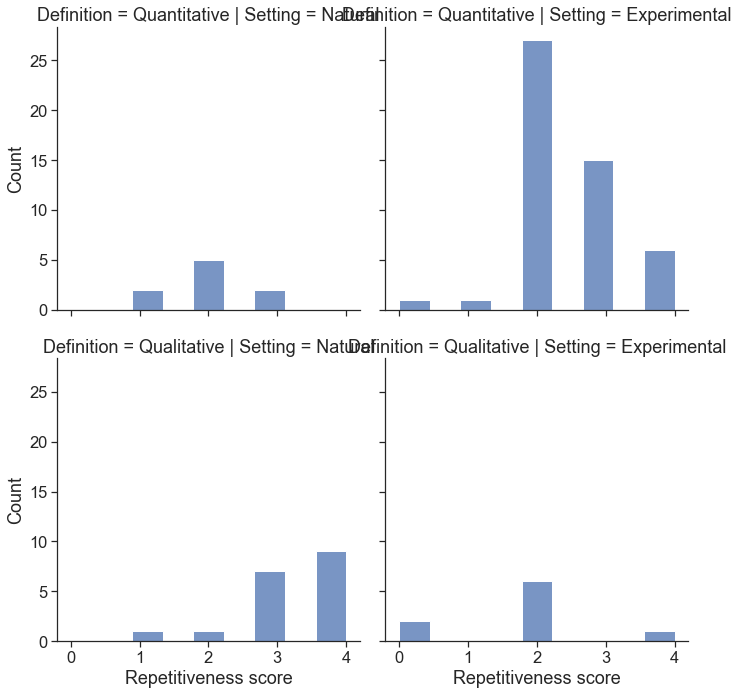

In [26]:
sns.displot(kind='hist',data=data, x='Repetitiveness score', col='Setting', row='Definition')
plt.show()

### Step 2: The distribution is not normal: we use the Kruskal-Wallis test.

In [27]:
qual_nat = list(data[(data.Definition=="Qualitative")&(data.Setting=="Natural")]["Repetitiveness score"])
qual_exp = list(data[(data.Definition=="Qualitative")&(data.Setting=="Experimental")]["Repetitiveness score"])
quant_nat = list(data[(data.Definition=="Quantitative")&(data.Setting=="Natural")]["Repetitiveness score"])
quant_exp = list(data[(data.Definition=="Quantitative")&(data.Setting=="Experimental")]["Repetitiveness score"])
print(scipy.stats.kruskal(qual_nat, qual_exp, quant_nat, quant_exp))

KruskalResult(statistic=21.577235532264478, pvalue=7.987032835856478e-05)


### Step 3: The test is significant, we do a post-hoc Dunn test.

In [28]:
post_hoc = sp.posthoc_dunn([qual_nat, qual_exp, quant_nat, quant_exp], p_adjust = 'bonferroni')
post_hoc

,1,2,3,4
1,1.000000,0.000755,0.001771,0.003541
2,0.000755,1.000000,1.000000,0.518150
3,0.001771,1.000000,1.000000,0.845519
4,0.003541,0.518150,0.845519,1.000000


There a significant difference between qual_nat and any other group

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Natural_Quantitative vs. Natural_Qualitative: Custom statistical test, P_val:7.547e-04
Experimental_Qualitative vs. Natural_Qualitative: Custom statistical test, P_val:1.771e-03
Experimental_Quantitative vs. Natural_Qualitative: Custom statistical test, P_val:3.541e-03


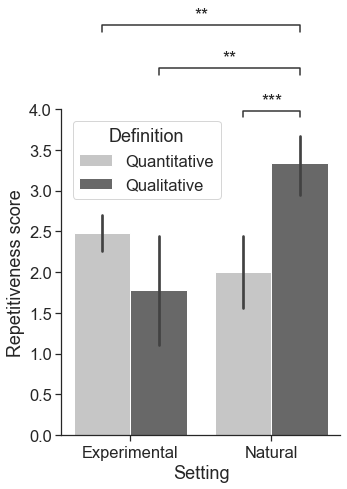

In [29]:
fig, ax = plt.subplots(1,1,figsize=(5,6))

sns.set(font_scale=1.5, style="ticks")
df = data.sort_values("Setting")

x = "Setting"
y = "Repetitiveness score"
hue = "Definition"
hue_order=['Quantitative', 'Qualitative']
order = ['Experimental', 'Natural']
pairs=[(("Natural", "Qualitative"), ("Natural", "Quantitative")),
       (("Natural", "Qualitative"), ("Experimental", "Qualitative")),
       (("Natural", "Qualitative"), ("Experimental", "Quantitative")),]
p_values = [post_hoc[1][2], post_hoc[1][3], post_hoc[1][4]]




sns.barplot(ax=ax, data=df, x=x, y=y, order=order, hue=hue, hue_order=hue_order, palette="Greys")

annot = Annotator(ax, pairs=pairs, data=df, x=x, y=y, order=order, hue=hue, hue_order=hue_order)

annot.configure(text_format="star", loc="inside")
annot.set_pvalues_and_annotate(p_values)

sns.despine(ax=ax,top=True, right=True)
plt.legend(title='Definition', bbox_to_anchor=(0.6, 0.7))
plt.ylim(0,4)
plt.show()

### Step 4: Test the relationship between 
- traplining scores and NN distances
- traplining scores and N feeding sites
for the bees only (because they are comparable species)

In [30]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['0', '1', '2', '3', '4'], ordered=True)


reg_dataNN = pd.DataFrame({})
reg_dataNN["TrapliningScore"] = data[data.Bee==True]["Repetitiveness score"].astype({"Repetitiveness score":str}).astype(cat_type)
reg_dataNN["NNDistance"] = data[data.Bee==True]["NN distance (m)"]
reg_dataNN = reg_dataNN.dropna()

reg_dataFS = pd.DataFrame({})
reg_dataFS["TrapliningScore"] = data[data.Bee==True]["Repetitiveness score"].astype({"Repetitiveness score":str}).astype(cat_type)
reg_dataFS["NFeedingSites"] = data[data.Bee==True]["N feeding sites"]
reg_dataFS["Available/used"] = data[data.Bee==True]["Available/used"]
reg_dataFS = reg_dataFS[reg_dataFS["Available/used"]=="Available"]
reg_dataFS = reg_dataFS.dropna()

I choose to use the log of those variables

In [31]:
reg_dataNN["logNNDistance"] = np.log(reg_dataNN["NNDistance"])
reg_dataFS["logNFeedingSites"] = np.log(reg_dataFS["NFeedingSites"])

Check the Kendall's tau-b:

In [32]:
print(scipy.stats.kendalltau(reg_dataNN["logNNDistance"], reg_dataNN["TrapliningScore"]))

KendalltauResult(correlation=0.606445179090462, pvalue=1.4318675755603462e-06)


In [33]:
print(scipy.stats.kendalltau(reg_dataFS["logNFeedingSites"], reg_dataFS["TrapliningScore"]))

KendalltauResult(correlation=-0.6050204723236409, pvalue=5.582234604623976e-06)


In [34]:
hum = list(data[(data.Group=="Hummingbirds")]["Repetitiveness score"])
ins = list(data[(data.Group=="Insects")]["Repetitiveness score"])
bat = list(data[(data.Group=="Bats")]["Repetitiveness score"])
oth = list(data[(data.Group=="Other birds")]["Repetitiveness score"])
herb = list(data[(data.Group=="Large herbivores")]["Repetitiveness score"])
prim = list(data[(data.Group=="Primates")]["Repetitiveness score"])
print(scipy.stats.kruskal(hum, ins, bat, oth, herb, prim))

KruskalResult(statistic=11.781077642337133, pvalue=0.037913827717770146)


In [35]:
post_hoc = sp.posthoc_dunn([hum, ins, bat, oth, herb, prim], p_adjust = 'bonferroni')
post_hoc

,1,2,3,4,5,6
1,1.000000,0.642455,1.0,1.000000,0.215278,0.668518
2,0.642455,1.000000,1.0,0.683837,1.000000,1.000000
3,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
4,1.000000,0.683837,1.0,1.000000,0.175624,0.544911
5,0.215278,1.000000,1.0,0.175624,1.000000,1.000000
6,0.668518,1.000000,1.0,0.544911,1.000000,1.000000
